# 以JAX的方式思考

JAX提供了一个简单而强大的API来编写加速的数值代码，不过有的时候，使用JAX有效地工作也需要稍加思索。本文档旨在帮助您全面了解JAX的运行方式，以便您可以更有效率地使用它。

## JAX vs. NumPy

**要点：**

* 为了方便起见，JAX提供了受NumPy启发的借口
* 通过[鸭子类型](https://zh.wikipedia.org/wiki/鸭子类型)(duck typing)，JAX数组通常可以直接替换NumPy数组。
* 与NumPy数组不同，JAX数组始终是不可变的。

NumPy 提供了用于处理数值数据众所周知且功能强大的API。为了方便起见，JAX提供了 `jax.numpy`，它与numpy API十分相似，并且给JAX提供了简易的入口。几乎所有可以使用 `numpy` 进行的操作都可以使用 `jax.numpy`：

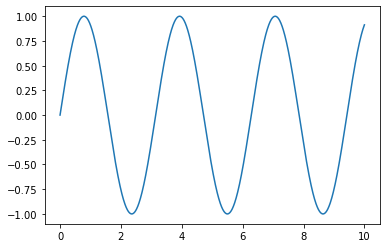

In [3]:
import matplotlib.pyplot as plt
import numpy as np

x_np = np.linspace(0, 10, 1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np)

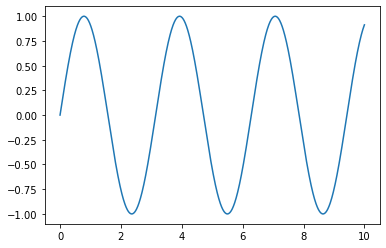

In [4]:
import jax.numpy as jnp

x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)

除了用`jnp` 替换 `np` 意外，这些代码基本是相同的，而且连结果也都一样。正如我们所见，JAX数组通常可以代替NumPy数组用于绘图之类的应用。

数组本身实现为不同的Python类型：

In [5]:
type(x_np)

numpy.ndarray

In [6]:
type(x_jnp)

jax.interpreters.xla._DeviceArray

Python的鸭子类型允许JAX数组和NumPy数组在许多地方互换使用。

但是，JAX和NumPy输足之间有一个重要的区别：JAX数组是不可变的，这意味着一旦创建，它们的内容就无法更改。

这是在NumPy中更改数组的示例：

In [7]:
# NumPy: mutable arrays
# NumPy: 可变数组

x = np.arange(10)
x[0] = 10
print(x)

[10  1  2  3  4  5  6  7  8  9]


等价的代码在JAX却是错误的，因为JAX数组是不可变的：

In [9]:
# JAX: immutable arrays
# JAX：不可变数组
x = jnp.arange(10)
x[0] = 10

TypeError: '<class 'jax.interpreters.xla._DeviceArray'>' object does not support item assignment. JAX arrays are immutable; perhaps you want jax.ops.index_update or jax.ops.index_add instead?

为了更新单个元素，JAX提供了索引更新语法，这个语法返回更新后的副本：

In [11]:
y = x.at[0].set(10)
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[10  1  2  3  4  5  6  7  8  9]


## NumPy, lax & XLA: JAX API 分层

**要点：**

* `jax.numpy`是提供熟悉借口的高层封装
* `jax.lax`是一个更底层的API，它更严格且更强大

所有的JAX都是根据XLA（加速线性代数编译器）中的运算实现的。

如果您查看 `jax.numpy`的源代码，您会发现所有操作最终都是用 `jax.lax` 中定义的函数表示的。您可以将 `jax.lax` 视为用于处理多维数组的更严格但通常更强大的API。

例如，虽然 `jax.numpy` 将隐式参数转换以允许在混合数据类型之间进行操作，但 `jax.lax()` 不会：

In [12]:
import jax.numpy as jnp
jnp.add(1, 1.0)

DeviceArray(2., dtype=float32)

In [13]:
from jax import lax
lax.add(1, 1.0)

TypeError: add requires arguments to have the same dtypes, got int32, float32.

如果直接使用`jax.lax`，您必须显示指定类型转换：

In [14]:
lax.add(jnp.float32(1), 1.0)

DeviceArray(2., dtype=float32)

除了这种严格性，`jax.lax`还为 NumPy 支持的一些更通用的操作提供了有效的API。 例如，考虑一维卷积，可以用这种方式在NumPy中表示：

In [15]:
x = jnp.array([1, 2, 1])
y = jnp.ones(10)
jnp.convolve(x, y)

DeviceArray([1., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 1.], dtype=float32)

在后台，此时NumPy操作被转换为由`lax.conv_general_dilated`实现的更通用的卷积：

In [17]:
from jax import lax

result = lax.conv_general_dilated(
    x.reshape(1, 1, 3).astype(float), #显示转换
    y.reshape(1, 1, 10),
    window_strides=(1, ),
    padding=[(len(y) - 1, len(y) - 1)])

result[0, 0]

DeviceArray([1., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 1.], dtype=float32)

这是一个批处理的卷积运算，旨在有效地处理深度神经网络中经常使用的卷积类型。他需要更多样板文件，但比NumPy提供的卷积要灵活的多（扩展性更强）。有关JAX卷积的跟过详细信息，请参见JAX[锋芒毕露：卷积]()。

从本质上讲，所有 `jax.lax`操作都是XLA中用于操作的Python包装器。例如，此处的卷积实现由 `XLA:ConvWithGeneralPadding`提供。最终，每个JAX操作都用这些基本XLA操作来表示，这就是急用即时编译（JIT）的原因。

## 是否使用JIT

**要点：**

* 默认情况下，JAX按顺序一次执行一个操作。
* 使用JIT编译装饰器时，可以一起优化操作序列并立即运行。
* 并非所有的JAX代码都可以JIT编译，因为它要求数组形状是静态的并且在编译时是已知的。

所有JAX操作均以XLA表示的事实允许JAX可以使用XLA编译器更有效地执行代码。例如，考虑一下函数，该函数以 `jax.numpy`操作的形式规范化2D矩阵的行：

In [18]:
import jax.numpy as jnp

def norm(X):
    X = X - X.mean(0)
    return X / X.std(0)

使用 `jax.jit`转换创建该函数的即时编译版本：

In [20]:
from jax import jit
norm_compiled = jit(norm)

此函数返回的结果与原始结果相同，且达到标准浮点精度：

In [21]:
np.random.seed(1701)
X = jnp.array(np.random.rand(10000, 10))
np.allclose(norm(X), norm_compiled(X), atol=1E-6)

True

但是由于编译（包括操作的融合，避免分配临时数组以及许多其他技巧），在JIT编译的情况下，执行时间可以快几个数量级（JAX的[异步调度](https://github.com/rasin-tsukuba/JAX_chinese_tutorial/blob/main/code/2.3-%E5%BC%82%E6%AD%A5%E8%B0%83%E5%BA%A6.ipynb)，请注意使用`block_until_ready()`来解决）：

In [22]:
%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

1.98 ms ± 31.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
62.2 µs ± 3.14 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


也就是说，`jax.jit`确由其局限性：特别是它要求所有数组都具有静态形状。这意味着某些JAX操作与JIT编译不兼容。例如，可以再逐个操作模式下执行此操作：

In [23]:
def get_negatives(x):
    return x[x < 0]

x = jnp.array(np.random.randn(10))
get_negatives(x)

DeviceArray([-0.10570311, -0.59403396, -0.8680282 , -0.23489487], dtype=float32)

但是，如果您尝试在jit模式下执行它，它将返回一个错误：

In [24]:
jit(get_negatives)(x)

IndexError: Array boolean indices must be concrete.

这是因为在编译时该函数生成一个形状未知的数组：输出的大小取决于输入数组的值，因此它与JIT不兼容。

## JIT机制：跟踪和静态变量

**要点：**

* JIT和其他JAX变换通过跟踪函数以确定其对特定形状和类型的输入的效果来工作。

* 不需要跟踪的变量可以标记为 *static* (静态)